In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax, jax.numpy as jnp, jax.random as jr
from muse_inference.jax import JaxMuseProblem
from ttictoc import tic, toc
from tqdm import tqdm
import pickle

In [3]:
def corrify(A):
    D = jnp.diag(jnp.sqrt(1 / jnp.diag(A)))
    return D @ A @ D

In [4]:
class WavyFunnel(JaxMuseProblem):

    def __init__(self, Nz, Nθ, A=None, **kwargs):
        super().__init__(**kwargs)
        self.Nz = Nz
        self.Nθ = Nθ
        self.A = A

    def A_times(self, x):
        return self.A @ x if self.A is not None else x
        
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (self.Nz, self.Nθ)) * jnp.exp(θ/2)
        x = self.A_times(z.flatten()) + jax.random.normal(keys[1], (z.size,))
        return (x, z)

    def logLike(self, x, z, θ):
        return -(jnp.sum((x - self.A_times(z.flatten()))**2) + jnp.sum(z**2 / jnp.exp(θ))) / 2

    def logPrior(self, θ):
        return -jnp.sum(θ**2) / (2*3**2)

In [5]:
θ_true = jnp.linspace(-2., 2, 10)
Nθ = θ_true.size
Nz = 64
N = Nz * Nθ
# A = jnp.tril(jr.normal(jr.PRNGKey(0), (N, N)))
A = jr.normal(jr.PRNGKey(1), (N, N))

prob_im = WavyFunnel(Nz, Nθ, A, implicit_diff=True)
prob_fd = WavyFunnel(Nz, Nθ, A, implicit_diff=False)
rng = jax.random.PRNGKey(0)
(x, z) = prob_im.sample_x_z(rng, θ_true)
prob_fd.set_x(x)
prob_im.set_x(x)

/global/u1/m/marius/.cache/pypoetry/virtualenvs/muse-inference-paper-cFBpulCB-py3.9/lib/python3.9/site-packages/jax/_src/api_util.py:220: SyntaxWarning: Jitted function has invalid argnames {'self'} in static_argnames. Function does not take these args.This warning will be replaced by an error after 2022-08-20 at the earliest.
  warnings.warn(f"Jitted function has invalid argnames {invalid_argnames} "


In [6]:
def time_H(Nθ, Nz_per_θ=None, Nz_total=None, z_tol=1e-1, nsims=40):
    
    θ_true = jnp.linspace(-2., 2, Nθ)
    Nθ = θ_true.size
    Nz = Nz_total // Nθ if Nz_total is not None else Nz_per_θ
    N = Nz * Nθ

    prob_im = WavyFunnel(Nz, Nθ, implicit_diff=True)
    prob_fd = WavyFunnel(Nz, Nθ, implicit_diff=False)

    # warmup
    prob_im.get_H(θ=θ_true, nsims=1, rng=jax.random.PRNGKey(1), z_tol=z_tol)
    prob_fd.get_H(θ=θ_true, nsims=1, rng=jax.random.PRNGKey(1), z_tol=z_tol)

    result_im = prob_im.get_H(θ=θ_true, nsims=nsims, rng=jax.random.PRNGKey(1), z_tol=z_tol)
    result_fd = prob_fd.get_H(θ=θ_true, nsims=nsims, rng=jax.random.PRNGKey(1), z_tol=z_tol)

    return (result_fd.time.total_seconds()/nsims, result_im.time.total_seconds()/nsims)

In [7]:
Nθs = list(2**arange(1, 12))
Nθs

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]

In [8]:
time_H_fixed_Nz_total = [time_H(Nθ, Nz_total=8192) for Nθ in tqdm(Nθs)]

100%|██████████| 11/11 [15:19<00:00, 83.58s/it] 


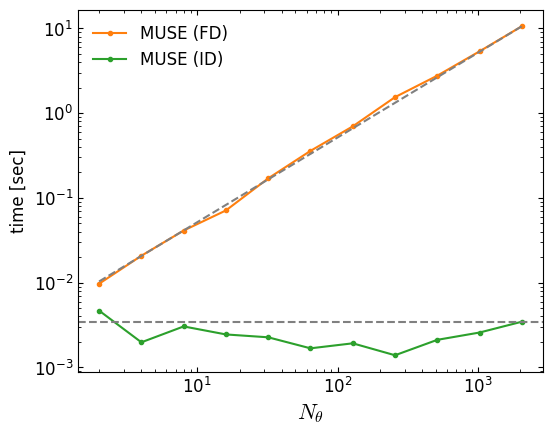

In [9]:
figure(figsize=(6,4.7))
loglog(Nθs, [t for (t,_) in time_H_fixed_Nz_total], "C1.-", label="MUSE (FD)")
loglog(Nθs, [t for (_,t) in time_H_fixed_Nz_total], "C2.-", label="MUSE (ID)")
_ylim = ylim()
loglog(Nθs, array(Nθs)/Nθs[-1]*time_H_fixed_Nz_total[-1][0], c="gray", ls="--")
axhline(time_H_fixed_Nz_total[-1][1], c="gray", ls="--")
ylim(_ylim)
xlabel(r"$N_\theta$")
ylabel("time [sec]", fontsize=12)
legend()
savefig("big_O_comparison.pdf", bbox_inches="tight")